<a href="https://colab.research.google.com/github/albert-yue/6864-hw1/blob/master/6864_hw1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf 6864-hw1
git clone https://github.com/lingo-mit/6864-hw1.git

Cloning into '6864-hw1'...


In [0]:
import sys
sys.path.append("/content/6864-hw1")

import csv
import itertools as it
import numpy as np
np.random.seed(0)

import lab_util

In [0]:
from matplotlib import pyplot as plt

## Hidden Markov Models

In the remaining part of the lab (containing part 3) you'll use the Baum--Welch algorithm to learn _categorical_ representations of words in your vocabulary. Answers to questions in this lab should go in the same report as the initial release.

As before, we'll start by loading up a dataset:

In [4]:
data = []
n_positive = 0
n_disp = 0
with open("/content/6864-hw1/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue
      n_positive += 1
    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue
    n_disp += 1
    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews = reviews[:3000]
train_labels = labels[:3000]
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

## HMM Implementation

Next, implement the forward--backward algorithm for HMMs like we saw in class.

**IMPORTANT NOTE**: if you directly multiply probabilities as shown on the class slides, you'll get underflow errors. You'll probably want to work in the log domain (remember that `log(ab) = log(a) + log(b)`, `log(a+b) = logaddexp(a, b)`).

In [0]:
import numpy as np
from scipy.special import logsumexp


# hmm model
class HMM(object):
    def __init__(self, num_states, num_words):
        self.num_states = num_states
        self.num_words = num_words

        self.states = range(num_states)
        self.symbols = range(num_words)

        self.eps = 1e-20  # small value for log probs of 0, i.e for beta_T

        # initialize the matrix A with random transition probabilities p(j|i)
        # A should be a matrix of size `num_states x num_states`
        # with rows that sum to 1
        self.A = np.random.rand(num_states, num_states)
        self.A = self.A / np.sum(self.A, axis=1, keepdims=True)

        # initialize the matrix B with random emission probabilities p(o|i)
        # B should be a matrix of size `num_states x num_words`
        # with rows that sum to 1
        self.B = np.random.rand(num_states, num_words)
        self.B = self.B / np.sum(self.B, axis=1, keepdims=True)

        # initialize the vector pi with a random starting distribution
        # pi should be a vector of size `num_states`
        self.pi = np.random.rand(num_states)
        self.pi = self.pi / np.sum(self.pi)

    def generate(self, n):
        """randomly sample the HMM to generate a sequence.
        """
        # we'll give you this one

        sequence = []
        # initialize the first state
        state = np.random.choice(self.states, p=self.pi)
        for i in range(n):
            # get the emission probs for this state
            b = self.B[state, :]
            # emit a word
            word = np.random.choice(self.symbols, p=b)
            sequence.append(word)
            # get the transition probs for this state
            a = self.A[state, :]
            # update the state
            state = np.random.choice(self.states, p=a)
        return sequence

    def forward(self, obs):
        # run the forward algorithm
        # this function should return a `len(obs) x num_states` matrix
        # where the (i, j)th entry contains p(obs[:t], hidden_state_t = i)

        log_alpha = np.zeros((len(obs), self.num_states))

        # your code here!
        # First time step: alpha_0(i) = pi_i B_i(o_0) for 0<=i<N
        # in logspace: log(alpha[0, i]) = log(pi_i) + log(B[i, o_0])
        log_alpha[0, :] = np.log(self.B[:, obs[0]]) + np.log(self.pi)

        # Further time steps: alpha ...
        for t in range(1, len(obs)):
            # log(alpha[t-1,i]) + log(self.A[i, j])
            # sum should match index in log_alpha with row index in self.A
            # so the term from log_alpha should broadcast one elem to each row
            log_trans_prob = np.log(self.A) + log_alpha[t-1, :][:, None]
            log_trans_prob_over_prevs = logsumexp(log_trans_prob, axis=0)  # sum over 1<=i<=N
            log_alpha[t, :] = log_trans_prob_over_prevs + np.log(self.B[:, obs[t]])

        return log_alpha

    def backward(self, obs):
        # run the backward algorithm
        # this function should return a `len(obs) x num_states` matrix
        # where the (i, j)th entry contains p(obs[t+1:] | hidden_state_t = i)

        log_beta = np.zeros((len(obs), self.num_states))
        T = len(obs)

        # beta for last time step is 1, log of which is 0
        # log_beta[T-1, :] = np.zeros((self.num_states,))
        
        # Further time steps: beta[t-1,i] = sum(j=0 to N-1) A[i,j] B[j,o_t] beta[t,j]
        for t in range(T-1, 0, -1):  # t is the time step for the future obs (=t+1 in the slides)
            # add same value to each column (constant j value)
            log_trans_prob = np.log(self.A) + np.log(self.B[:, obs[t]][None, :]) + log_beta[t, :][None, :]
            log_beta[t-1, :] = logsumexp(log_trans_prob, axis=1)

        return log_beta
        
    def forward_backward(self, obs):
        # compute forward-backward scores

        # logprob is the total log-probability of the sequence obs 
        # (marginalizing over hidden states)

        # log_gamma is a matrix of size `len(obs) x num_states`
        # it contains the marginal log probability of being in state i at time t

        # log_xi is a tensor of size `len(obs) x num_states x num_states`
        # it contains the marginal log probability of transitioning from i to j at t

        log_alpha = self.forward(obs)  # T=len(obs) x num_states
        log_beta = self.backward(obs)  # T x num_states
        
        logprob = logsumexp(log_alpha[len(obs)-1, :])

        logprob_backward = logsumexp(np.log(self.pi) + np.log(self.B[:, obs[0]]) + log_beta[0, :])

        # Compute log_xi
        # log_xi[t,i,j] = log_alpha[t,i] + np.log(self.A[i,j]) + np.log(self.B[j,obs[t+1]]) + log_beta[t+1,j] - logprob
        log_xi = np.zeros((len(obs), self.num_states, self.num_states))
        
        # shift B and beta to have info from timestep t+1 in index t
        relevant_B = np.hstack((self.B[:, obs[1:]], np.ones((self.num_states, 1))))
        relevant_logbeta = np.vstack((log_beta[1:, :], np.ones((1, self.num_states))))
        
        # change dimensions of the four matrices for broadcasting
        new_log_A = np.tile(np.expand_dims(np.log(self.A), axis=0), (len(obs), 1, 1))
        new_log_alpha = np.expand_dims(log_alpha, axis=2)
        new_log_B = np.expand_dims(np.log(relevant_B.T), axis=1)
        new_log_beta = np.expand_dims(relevant_logbeta, axis=1)

        # print(new_log_A.shape)
        # print(new_log_alpha.shape)
        # print(new_log_B.shape)
        # print(new_log_beta.shape)
        log_xi = new_log_A + new_log_alpha + new_log_B + new_log_beta - logprob
        
        # Compute log_gamma
        log_gamma = np.zeros((len(obs), self.num_states))
        log_gamma = log_alpha + log_beta - logprob

        return logprob, log_xi, log_gamma

    def learn_unsupervised(self, corpus, num_iters, verbose=True):
        """Run the Baum Welch EM algorithm
        """

        for i_iter in range(num_iters):
            expected_si = np.full((self.num_states, ), self.eps)  # E(si -> s*): shape (num_states,)
            expected_sij = np.full((self.num_states, self.num_states), self.eps)  # E(si -> sj): shape (num_states, num_states)
            expected_sj = np.full((self.num_states,), self.eps)  # E(sj): shape (num_states,)
            expected_sjwk = np.full((self.num_states, self.num_words), self.eps)  # E(sj,wk): shape (num_states, num_words)
            total_logprob = 0
            for i, review in enumerate(corpus):
                logprob, log_xi, log_gamma = self.forward_backward(review)
                # your code here 
                total_logprob += logprob

                words_onehot = np.eye(self.num_words)[review]
                max_log_gamma = np.max(log_gamma)
                simplified_gamma = np.exp(log_gamma - max_log_gamma)
                simp_gamma_by_word = simplified_gamma.T @ words_onehot + self.eps  # add epsilon for zeros
                log_gamma_by_word = np.log(simp_gamma_by_word) + max_log_gamma
                
                if i == 0:
                    expected_si = logsumexp(log_gamma[0:-1], axis=0)
                    expected_sij = logsumexp(log_xi[0:-1], axis=0)
                    expected_sj = logsumexp(log_gamma, axis=0)
                    expected_sjwk = log_gamma_by_word
                else:
                    np.logaddexp(expected_si, logsumexp(log_gamma[0:-1], axis=0), out=expected_si)
                    np.logaddexp(expected_sij, logsumexp(log_xi[0:-1], axis=0), out=expected_sij)
                    np.logaddexp(expected_sj, logsumexp(log_gamma, axis=0), out=expected_sj)

                    np.logaddexp(expected_sjwk, log_gamma_by_word, out=expected_sjwk)

            if verbose: print("log-likelihood", total_logprob)
            # print(expected_sij)
            # print(expected_si)
            # print(expected_sjwk.shape, expected_sj.shape)
            # print(expected_sjwk)
            # print(expected_sj)
            A_new = np.exp(expected_sij - expected_si[:, None])
            B_new = np.exp(expected_sjwk - expected_sj[:, None])
            # print("A_new:", A_new)
            # print(np.sum(A_new, axis=1, keepdims=True))
            # print(B_new.shape)

            self.A = A_new / np.sum(A_new, axis=1, keepdims=True)
            self.B = B_new / np.sum(B_new, axis=1, keepdims=True)

## Testing

In [6]:
corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
hmm = HMM(num_states=2, num_words=4)
hmm.learn_unsupervised(corpus, 1000, verbose=False)
print(np.round(hmm.B, 2))
print()
hmm.generate(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log


[[0.   0.5  0.27 0.23]
 [0.52 0.   0.24 0.24]]



[1, 3, 1, 1, 3, 3, 2, 1, 1, 3]

In [7]:
corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
hmm = HMM(num_states=2, num_words=4)

obs = corpus[0]
log_alpha = hmm.forward(obs)
alpha = np.exp(log_alpha)
print("alpha:", alpha)
print("pi:", hmm.pi)
print("B:", hmm.B)

# print(alpha[0, 0], hmm.pi[0] * hmm.B[0, obs[0]])
for i in range(hmm.num_states):
  assert np.isclose(alpha[0, i], hmm.pi[i] * hmm.B[i, obs[0]])

for t in range(1, len(obs)):
  for j in range(hmm.num_states):
    prev_sum = 0
    for i in range(hmm.num_states):
      prev_sum += alpha[t-1, i] * hmm.A[i, j]
    res = hmm.B[j, obs[t]] * prev_sum
    # print(alpha[t,j], res)
    assert np.isclose(alpha[t, j], res)

alpha: [[2.14839665e-01 1.38796425e-01]
 [1.47412296e-02 6.37276832e-02]
 [8.07696426e-03 2.53086511e-02]
 [1.67647572e-03 5.54125827e-03]
 [7.27979669e-04 2.35249833e-03]
 [1.55090965e-04 5.10617255e-04]
 [6.71215093e-05 2.17012015e-04]
 [1.43056829e-05 4.70967427e-05]
 [6.19100440e-06 2.00164248e-05]
 [1.31950432e-06 4.34402858e-06]
 [5.71035329e-07 1.84624115e-06]
 [1.21706207e-07 4.00677151e-07]]
pi: [0.71762307 0.28237693]
B: [[0.29937675 0.25750521 0.2933972  0.14972084]
 [0.49152891 0.21118213 0.0475508  0.24973817]]


In [8]:
corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
hmm = HMM(num_states=2, num_words=4)

obs = corpus[0]
log_beta = hmm.backward(obs)
beta = np.exp(log_beta)
print("beta:", beta)
# print("pi:", hmm.pi)
# print("B:", hmm.B)

for i in range(hmm.num_states):
  assert np.isclose(beta[len(obs)-1, i], 1)

for t in range(len(obs)-2, -1, -1):
  for i in range(hmm.num_states):
    fut_sum = 0
    for j in range(hmm.num_states):
      fut_sum += hmm.A[i,j] * hmm.B[j, obs[t+1]] * beta[t+1, j]
    assert np.isclose(beta[t, i], fut_sum)

beta: [[2.70381525e-05 2.98880927e-05]
 [9.17308160e-05 9.48983330e-05]
 [1.72712937e-04 1.90917640e-04]
 [5.85953447e-04 6.06186749e-04]
 [1.10324694e-03 1.21953399e-03]
 [3.74292421e-03 3.87216870e-03]
 [7.04727104e-03 7.79007335e-03]
 [2.39090566e-02 2.47343684e-02]
 [4.50184099e-02 4.97596750e-02]
 [1.52793548e-01 1.57971024e-01]
 [2.88340511e-01 3.17376018e-01]
 [1.00000000e+00 1.00000000e+00]]


In [9]:
from scipy.special import logsumexp

corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
hmm = HMM(num_states=2, num_words=4)

obs = corpus[0]
log_alpha = hmm.forward(obs)
alpha = np.exp(log_alpha)
log_beta = hmm.backward(obs)
beta = np.exp(log_beta)

prob_forward = 0
for i in range(hmm.num_states):
  prob_forward += alpha[len(obs)-1, i]

prob_backward = 0
for i in range(hmm.num_states):
  prob_backward += hmm.pi[i] * hmm.B[i, obs[0]] * beta[0, i]

print(prob_forward, prob_backward)
assert np.isclose(prob_forward, prob_backward)
print(np.log(prob_forward), np.log(prob_backward))

logprob_forward = logsumexp(log_alpha[len(obs)-1, :])
logprob_backward = logsumexp(np.log(hmm.pi) + np.log(hmm.B[:, obs[0]]) + log_beta[0, :])

print(logprob_forward)
print(logprob_backward)

assert np.isclose(np.log(prob_forward), logprob_forward)
assert np.isclose(np.log(prob_forward), logprob_backward)
assert np.isclose(np.log(prob_backward), logprob_forward)
assert np.isclose(np.log(prob_backward), logprob_backward)

2.429158639789488e-07 2.42915863978949e-07
-15.230550692330104 -15.230550692330102
-15.230550692330104
-15.230550692330102


In [10]:
corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
hmm = HMM(num_states=2, num_words=4)

obs = corpus[0]

log_alpha = hmm.forward(obs)  # T=len(obs) x num_states
log_beta = hmm.backward(obs)  # T x num_states

logprob = logsumexp(log_alpha[len(obs)-1, :])
log_gamma = np.zeros((len(obs), hmm.num_states))
log_xi = np.zeros((len(obs), hmm.num_states, hmm.num_states))

logprob_backward = logsumexp(np.log(hmm.pi) + np.log(hmm.B[:, obs[0]]) + log_beta[0, :])

# log_xi[t,i,j] = log_alpha[t,i] + np.log(self.A[i,j]) + np.log(self.B[j,obs[t+1]]) + log_beta[t+1,j] - logprob
relevant_B = np.hstack((hmm.B[:, obs[1:]], np.ones((hmm.num_states, 1))))
# print(relevant_B)
# print(np.log(relevant_B))
relevant_logbeta = np.vstack((log_beta[1:, :], np.zeros((1, hmm.num_states))))
# print(log_beta)
# print(relevant_logbeta)

# print(np.tile(np.expand_dims(np.log(hmm.A), axis=0), (len(obs), 1, 1)).shape)
# print(np.tile(np.expand_dims(np.log(hmm.A), axis=0), len(obs)))
new_log_A = np.tile(np.expand_dims(np.log(hmm.A), axis=0), (len(obs), 1, 1))

new_log_alpha = np.expand_dims(log_alpha, axis=2)
# print(new_log_alpha.shape)
# print(new_log_alpha[0])

# print(new_log_A[0])
# print((new_log_A + new_log_alpha)[0])

new_log_B = np.expand_dims(np.log(relevant_B.T), axis=1)
# print(new_log_B)

new_log_beta = np.expand_dims(relevant_logbeta, axis=1)
# print(new_log_beta.shape)

log_xi = new_log_A + new_log_alpha + new_log_B + new_log_beta - logprob

# log_xi[t,:,:] = np.log(hmm.A) + log_alpha[t, :][:, None] + np.log(relevant_B)[:, t][None, :] + relevant_logbeta[t, :][None, :] - logprob

t=0
log_expected = np.zeros((hmm.num_states, hmm.num_states))
for i in range(hmm.num_states):
  for j in range(hmm.num_states):
    log_expected[i,j] = np.log(hmm.A[i,j]) + log_alpha[t, i] + np.log(hmm.B[j, obs[t+1]]) + log_beta[t+1, j] - logprob


print(log_xi[0,:,:])
print(log_expected)
# print("-----")
# print(np.log(hmm.A))
# print(log_alpha[t, :][:, None])
# print(np.log(relevant_B)[:, t][None, :])
# print(relevant_logbeta[t, :][None, :])

[[-1.20548595 -2.03378722]
 [-1.57088655 -1.01679165]]
[[-1.20548595 -2.03378722]
 [-1.57088655 -1.01679165]]


In [0]:
corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
hmm = HMM(num_states=2, num_words=4)

obs = corpus[0]

log_alpha = hmm.forward(obs)
alpha = np.exp(log_alpha)
logprob_forward = logsumexp(log_alpha[len(obs)-1, :])

log_beta = hmm.backward(obs)
beta = np.exp(log_beta)

logprob, log_xi, log_gamma = hmm.forward_backward(obs)
xi = np.exp(log_xi)
gamma = np.exp(log_gamma)

# make sure logprob matches what we'd expect 
assert np.isclose(logprob, logprob_forward)

# values for t = T (i.e. len(obs)-1) don't matter for updates
# full_log_expected = np.zeros((len(obs), hmm.num_states, hmm.num_states))
for t in range(len(obs)-1):
  for i in range(hmm.num_states):
    for j in range(hmm.num_states):
      expected = alpha[t, i] * hmm.A[i,j] * hmm.B[j, obs[t+1]] * beta[t+1, j] / np.exp(logprob)
      log_expected = log_alpha[t, i] + np.log(hmm.A[i,j]) + np.log(hmm.B[j, obs[t+1]]) + log_beta[t+1, j] - logprob
      # full_log_expected[t,i,j] = log_expected
      assert np.isclose(log_xi[t, i, j], log_expected), "Expected log_xi value: {} but got {}".format(log_expected, log_xi[t, i, j])
      assert np.isclose(xi[t, i, j], expected), "Expected xi value: {} but got {}".format(expected, xi[t, i, j])

# for t in range(len(obs)):
#   print('t =', t)
#   print(log_xi[t])
#   print(full_log_expected[t])
#   print('---')

# skip the last time step, since xi won't match here
for t in range(len(obs)-1):
  for i in range(hmm.num_states):
    expected = 0
    for j in range(hmm.num_states):
      expected += xi[t,i,j]
    assert np.isclose(gamma[t,i], expected), "At time {} and state {}, expected {} but got {}".format(t, i, expected, gamma[t,i])

assert np.allclose(np.sum(gamma, axis=1), 1)

In [12]:
# Not sure what to set the last column in relevant_B and relevant_logbeta
# to get the right values for the last time step
gamma_from_xi_last_time = np.zeros((hmm.num_states,))
for i in range(hmm.num_states):
  expected = 0
  for j in range(hmm.num_states):
    expected += xi[-1,i,j]
  gamma_from_xi_last_time[i] = expected

print(gamma_from_xi_last_time)
print(gamma[-1, :])

[1.28970038 1.42858145]
[0.47445426 0.52554574]


In [0]:
corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], [0,2,0,2,0,2,0,2,0,2,0,2,0], [1,2,1,2,1,2,1,2,1,2,1,2],[1,3,1,3,1,3,1,3,1,3]])
hmm = HMM(num_states=2, num_words=4)

total_logprob = 0
for i, review in enumerate(corpus):
    logprob, log_xi, log_gamma = hmm.forward_backward(review)
    # your code here 
    total_logprob += logprob

    words_onehot = np.eye(hmm.num_words)[review]
    max_log_gamma = np.max(log_gamma)
    simplified_gamma = np.exp(log_gamma - max_log_gamma)
    simp_gamma_by_word = simplified_gamma.T @ words_onehot + hmm.eps  # add epsilon for zeros
    log_gamma_by_word = np.log(simp_gamma_by_word) + max_log_gamma
    
    if i == 0:
        expected_si = logsumexp(log_gamma[0:-1], axis=0)
        expected_sij = logsumexp(log_xi[0:-1], axis=0)
        expected_sj = logsumexp(log_gamma, axis=0)
        expected_sjwk = log_gamma_by_word
    else:
        np.logaddexp(expected_si, logsumexp(log_gamma[0:-1], axis=0), out=expected_si)
        np.logaddexp(expected_sij, logsumexp(log_xi[0:-1], axis=0), out=expected_sij)
        np.logaddexp(expected_sj, logsumexp(log_gamma, axis=0), out=expected_sj)

        np.logaddexp(expected_sjwk, log_gamma_by_word, out=expected_sjwk)

wanted_si = np.zeros((hmm.num_states, ))
wanted_sij = np.zeros((hmm.num_states, hmm.num_states))  # E(si -> sj): shape (num_states, num_states)
wanted_sj = np.zeros((hmm.num_states,))  # E(sj): shape (num_states,)
wanted_sjwk = np.zeros((hmm.num_states, hmm.num_words))  # E(sj,wk): shape (num_states, num_words)
for idx, review in enumerate(corpus):
    log_alpha = hmm.forward(review)
    alpha = np.exp(log_alpha)
    logprob_forward = logsumexp(log_alpha[len(review)-1, :])

    log_beta = hmm.backward(review)
    beta = np.exp(log_beta)

    logprob, log_xi, log_gamma = hmm.forward_backward(review)
    xi = np.exp(log_xi)
    gamma = np.exp(log_gamma)

    for i in range(hmm.num_states):
        for t in range(len(review)-1):
            wanted_si[i] += gamma[t,i]
    
    for i in range(hmm.num_states):
        for j in range(hmm.num_states):
            for t in range(len(review)-1):
                wanted_sij[i,j] += xi[t,i,j]
    
    for j in range(hmm.num_states):
        for t in range(len(review)):
            wanted_sj[j] += gamma[t,j]

    # if idx != 0: continue
    # print(gamma)
    # print(review)
    for j in range(hmm.num_states):
        for w in range(hmm.num_words):
            for t in range(len(review)):
                if review[t] == w:
                    wanted_sjwk[j, w] += gamma[t,j]

for i in range(hmm.num_states):
    # print(expected_si[i], np.log(wanted_si[i]))
    # print(np.exp(expected_si[i]), wanted_si[i])
    assert np.isclose(expected_si[i], np.log(wanted_si[i]))

for i in range(hmm.num_states):
    for j in range(hmm.num_states):
        assert np.isclose(expected_sij[i,j], np.log(wanted_sij[i,j]))

# print(expected_sj)
# print(np.log(wanted_sj))
for j in range(hmm.num_states):
    assert np.isclose(expected_sj[j], np.log(wanted_sj[j]))

# print(expected_sjwk)
# print(np.log(wanted_sjwk))
for i in range(hmm.num_states):
    for w in range(hmm.num_words):
        assert np.isclose(expected_sjwk[i,w], np.log(wanted_sjwk[i,w]))

# np.logaddexp(expected_sij, logsumexp(log_xi[0:-1], axis=0), out=expected_sij)
# np.logaddexp(expected_sj, logsumexp(log_gamma, axis=0), out=expected_sj)

# words_onehot = np.eye(self.num_words)[review]
# max_log_gamma = np.max(log_gamma)
# simplified_gamma = np.exp(log_gamma - max_log_gamma)
# simp_gamma_by_word = simplified_gamma.T @ words_onehot + self.eps  # add epsilon for zeros
# log_gamma_by_word = np.log(simp_gamma_by_word) + max_log_gamma

# np.logaddexp(expected_sjwk, log_gamma_by_word, out=expected_sjwk)

## Experiments

Train a model:

In [318]:
tokenizer = lab_util.Tokenizer()
tokenizer.fit(train_reviews)
train_reviews_tk = tokenizer.tokenize(train_reviews)
print(tokenizer.vocab_size)

hmm = HMM(num_states=10, num_words=tokenizer.vocab_size)
hmm.learn_unsupervised(train_reviews_tk, 10)

2006
log-likelihood -2089917.1991944504
log-likelihood -1524887.1304268788
log-likelihood -1524185.523647732
log-likelihood -1523412.772067245
log-likelihood -1522495.8381112337
log-likelihood -1521350.8320171814
log-likelihood -1519871.4118507395
log-likelihood -1517913.31245186
log-likelihood -1515272.647603099
log-likelihood -1511661.0869601287


Let's look at some of the words associated with each hidden state:

In [275]:
for i in range(hmm.num_states):
    most_probable = np.argsort(hmm.B[i, :])[::-1][:10]
    print(f"state {i}")   
    for o in most_probable:
        print(tokenizer.token_to_word[o], hmm.B[i, o])
    print()

state 0
. 0.09441054242543682
i 0.07375932838554647
<unk> 0.035941882391585966
it 0.03331877851197925
, 0.03106381307967656
they 0.03023826336974981
that 0.022137165229001256
and 0.020421180373083766
not 0.019489947629475077
you 0.014195313828903622

state 1
br 0.12176408273555041
, 0.09291446561364468
<unk> 0.09034711996799845
. 0.0659456278307458
the 0.033882367610778695
but 0.024677347973385864
i 0.021000502852190524
this 0.01950368593574959
is 0.019205750882931572
it 0.018451345223994327

state 2
. 0.08378024253532976
the 0.08316872013124443
<unk> 0.06267266463746844
i 0.04092554562746479
to 0.02792907382439079
of 0.02121551827847617
and 0.020749482167022375
this 0.017798106510406583
, 0.01753363453933246
my 0.015819512005304567

state 3
a 0.06877201431996974
<unk> 0.054663486178699
and 0.053593120003017795
the 0.05108793288252669
to 0.04970410656083046
. 0.038678973627255274
, 0.03763810530416528
not 0.034643715563881336
in 0.02224082604480798
little 0.013879539547936607

state 4


We can also look at some samples from the model!

In [320]:
for i in range(10):
    print(tokenizer.de_tokenize([hmm.generate(10)]))

['during <unk> i up all , br i in single']
['just <unk> baby bag for salty ! tastes want go']
['cats plus away i get <unk> show found i stick']
['form <unk> <unk> when yes i times would little and']
['snack salt changed saw not , ! from have spent']
['<unk> the choices and a <unk> company or easily do']
['spread good healthier being but pack com my had just']
['<unk> less , . around ! <unk> much taste other']
['i bag them immediately protein my you taste . sodas']
['along if but pancake would the , some healthier unpleasant']


Finally, let's repeat the classification experiment from Parts 1 and 2, using the _vector of expected hidden state counts_ as a sentence representation.

(Warning! results may not be the same as in earlier versions of this experiment.)

In [321]:
def train_model(xs_featurized, ys):
  import sklearn.linear_model
  model = sklearn.linear_model.LogisticRegression()
  model.fit(xs_featurized, ys)
  return model

def eval_model(model, xs_featurized, ys, verbose=True):
  pred_ys = model.predict(xs_featurized)
  if verbose: print("test accuracy", np.mean(pred_ys == ys))
  return np.mean(pred_ys == ys)

def training_experiment(name, featurizer, n_train, verbose=True):
    if verbose: print(f"{name} features, {n_train} examples")
    train_xs = np.array([
        hmm_featurizer(tokenizer.tokenize([review])) 
        for review in train_reviews[:n_train]
    ])
    train_ys = train_labels[:n_train]
    test_xs = np.array([
        hmm_featurizer(tokenizer.tokenize([review]))
        for review in test_reviews
    ])
    test_ys = test_labels
    model = train_model(train_xs, train_ys)
    acc = eval_model(model, test_xs, test_ys)
    if verbose: print()
    return acc

def hmm_featurizer(review):
    review = review[0]
    _, _, gamma = hmm.forward_backward(review)
    return gamma.sum(axis=0)

training_experiment("hmm", hmm_featurizer, n_train=100)

hmm features, 100 examples
test accuracy 0.508



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.508

**Part 3: Lab writeup**

1. What do the learned hidden states seem to encode when you run unsupervised 
   HMM training with only 2 states? What about 10? What about 100?

2. As before, what's the relationship between # of labeled examples and    
   usefulness of HMM-based sentence representations? Are these results generally
   better or worse than in Parts 1 and 2 of the homework? Why or why not might
   HMM state distributions be sensible sentence representations?

In [322]:
# To find lower limit for logistic regression convergence
train_sizes = [200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

for n in train_sizes:
    training_experiment("hmm", hmm_featurizer, n_train=n)

hmm features, 200 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.574

hmm features, 300 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.642

hmm features, 500 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.602

hmm features, 750 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.606

hmm features, 1000 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.612

hmm features, 1500 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.614

hmm features, 2000 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.618

hmm features, 2500 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.616

hmm features, 3000 examples
test accuracy 0.616



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [323]:
# jk looks like all are bad for #states=10
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

hmm_10_results = []

for n in train_sizes:
    hmm_10_results.append(training_experiment("hmm", hmm_featurizer, n_train=n, verbose=False))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.468


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.45


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.444


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.422


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.414


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.508


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.574


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.642


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.602


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.606


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.612


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.614


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.618


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.616
test accuracy 0.616


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


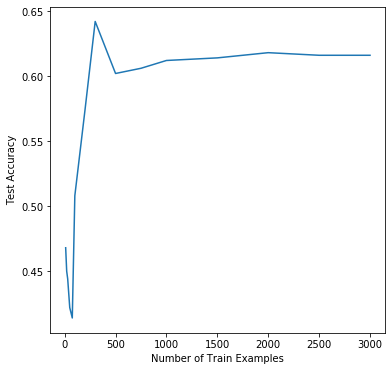

In [330]:
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, hmm_10_results, label="hmm")
# plt.legend(loc = "lower right")
# plt.title('Test Accuracy of HMM-based Representations with 10 Hidden States on Different Train Data Sizes')
plt.xlabel('Number of Train Examples')
plt.ylabel('Test Accuracy')

# plt.savefig('hmm_ntrain.png')
# files.download('hmm_ntrain.png')
plt.show()

In [14]:
tokenizer = lab_util.Tokenizer()
tokenizer.fit(train_reviews)
train_reviews_tk = tokenizer.tokenize(train_reviews)
print(tokenizer.vocab_size)

hmm2 = HMM(num_states=2, num_words=tokenizer.vocab_size)
hmm2.learn_unsupervised(train_reviews_tk, 10)

for i in range(hmm2.num_states):
    most_probable_2 = np.argsort(hmm2.B[i, :])[::-1][:10]
    print(f"state {i}")   
    for o in most_probable_2:
        print(tokenizer.token_to_word[o], hmm2.B[i, o])
    print()

2006
log-likelihood -2091938.7828791158
log-likelihood -1525759.6139374922
log-likelihood -1525452.544514095
log-likelihood -1525196.4582913124
log-likelihood -1524963.8515883384
log-likelihood -1524736.7491449362
log-likelihood -1524502.0284070147
log-likelihood -1524249.7522469894
log-likelihood -1523972.7658050563
log-likelihood -1523666.0009118551
state 0
<unk> 0.10173966058336177
and 0.043608580042030824
the 0.029500988164168577
i 0.028734435183907198
it 0.028385692301300905
to 0.02548693917115605
of 0.02425388747515287
. 0.019874445558347602
br 0.0189519945042716
for 0.013088892881360028

state 1
. 0.11489358919612605
, 0.06314141567349009
<unk> 0.050067477457172715
the 0.04707051540179577
a 0.034755652784691886
i 0.030292078886628146
is 0.021600135446078216
this 0.017817989953622652
that 0.013896192304025948
as 0.010761163716723036



In [15]:
for i in range(10):
    print(tokenizer.de_tokenize([hmm.generate(10)]))

['not <unk> <unk> are are <unk> are not are <unk>']
['are are <unk> these <unk> not not are are are']
['not are not <unk> <unk> <unk> not are not <unk>']
['are not <unk> are are not not are <unk> these']
['<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> not not']
['<unk> not not are <unk> <unk> not are not not']
['<unk> not are <unk> not not not <unk> <unk> not']
['<unk> <unk> <unk> <unk> not <unk> these <unk> <unk> are']
['are not <unk> not not not <unk> are <unk> not']
['not not these <unk> <unk> <unk> these <unk> not <unk>']


In [16]:
tokenizer50 = lab_util.Tokenizer()
tokenizer50.fit(train_reviews)
train_reviews_tk = tokenizer50.tokenize(train_reviews)
print(tokenizer50.vocab_size)

hmm50 = HMM(num_states=50, num_words=tokenizer50.vocab_size)
hmm50.learn_unsupervised(train_reviews_tk, 10)

2006
log-likelihood -2078086.4314356584
log-likelihood -1525345.931128712
log-likelihood -1525212.8916231303
log-likelihood -1525077.4076970222
log-likelihood -1524935.6948303515
log-likelihood -1524783.3620497612
log-likelihood -1524614.9498223907
log-likelihood -1524423.254373716
log-likelihood -1524198.2785475415
log-likelihood -1523925.5468200485


In [23]:
for i in range(hmm50.num_states):
    most_probable = np.argsort(hmm50.B[i, :])[::-1][:10]
    print(f"state {i}")   
    for o in most_probable:
        print(tokenizer50.token_to_word[o], hmm50.B[i, o])
    print()

state 0
. 0.13357598539401402
and 0.04970710984142213
to 0.03713581602758531
i 0.034144943706297386
it 0.03213097577305458
<unk> 0.020755137834818856
a 0.015988097084972275
, 0.015592170407548204
the 0.015038233535990209
in 0.012332338550948951

state 1
the 0.07098796264524891
<unk> 0.05716581508292614
. 0.048512197025335664
a 0.04809956021703975
and 0.03629223329029702
it 0.0353653557046032
, 0.02844681053321185
is 0.01922100994796981
in 0.016030475683709956
to 0.015323226765717315

state 2
the 0.06906881457874227
, 0.06146344152279113
<unk> 0.04452558688897632
it 0.03938063072879583
. 0.034586832626620316
and 0.026818188668161786
for 0.021916794594798044
in 0.02032497462957678
to 0.018473802180453323
with 0.013388953633070222

state 3
i 0.09197383181700625
<unk> 0.08941947287110451
, 0.05365318935811315
. 0.038321170103563514
of 0.03149647371717822
a 0.0173919461158527
these 0.016526935189500446
this 0.016473758166895586
and 0.012964459883268383
br 0.012913661404696533

state 4
<unk>

In [25]:
for i in range(10):
    print(tokenizer50.de_tokenize([hmm50.generate(10)]))

['allergic a it br over you purchase only about for']
['it what one in have chips if <unk> in is']
["the tastes flowers during when but to and doesn't more"]
['just . this still if i are eaten the i']
['with , . br calories high over me when toddler']
['crunchy powder since school br again to their of i']
['perfect pack . and 10 <unk> , brands high it']
['come eat amazon other am have . i much i']
['. product i contained <unk> ! looking but coffee away']
['packaging is it caramel actually br br with these how']


In [327]:
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

hmm_50_results = []

def hmm50_featurizer(review):
    review = review[0]
    _, _, gamma = hmm50.forward_backward(review)
    return gamma.sum(axis=0)

for n in train_sizes:
    hmm_50_results.append(training_experiment("hmm", hmm50_featurizer, n_train=n))

hmm features, 10 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.468

hmm features, 20 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.45

hmm features, 30 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.444

hmm features, 50 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.422

hmm features, 75 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.414

hmm features, 100 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.508

hmm features, 200 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.574

hmm features, 300 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.642

hmm features, 500 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.602

hmm features, 750 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.606

hmm features, 1000 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.612

hmm features, 1500 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.614

hmm features, 2000 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.618

hmm features, 2500 examples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test accuracy 0.616

hmm features, 3000 examples
test accuracy 0.616



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


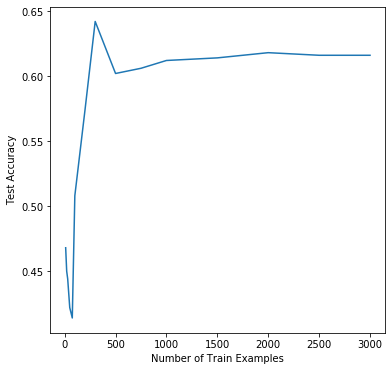

In [331]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(train_sizes, hmm_50_results, label="hmm")
# plt.legend(loc = "lower right")
# plt.title('Test Accuracy of HMM-based Representations with 50 Hidden States on Different Train Data Sizes')
plt.xlabel('Number of Train Examples')
plt.ylabel('Test Accuracy')

# plt.savefig('hmm_ntrain.png')
# files.download('hmm_ntrain.png')
plt.show()

In [329]:
tokenizer = lab_util.Tokenizer()
tokenizer.fit(train_reviews)
train_reviews_tk = tokenizer.tokenize(train_reviews)
print(tokenizer.vocab_size)

hmm100 = HMM(num_states=100, num_words=tokenizer.vocab_size)
hmm100.learn_unsupervised(train_reviews_tk, 10)

2006
log-likelihood -2073205.3254522625


KeyboardInterrupt: ignored